# Neural Networks (Optimized)

## 1. Import Libraries and Setup

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score, 
    roc_curve
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import BinaryFocalCrossentropy

# set random seeds
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load Dataset

In [3]:
# Load the dataset
df = pd.read_csv('churn_data_cleaned.csv')

## 3. Prepare Train-Test Split

Split the data into training (80%) and testing (20%) sets with stratification to maintain class distribution.

In [4]:
# Separate features and target
X = df.drop('TARGET', axis=1)
y = df['TARGET']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution
)

## 4. Feature Scaling

Neural networks require standardized features for optimal performance. We use StandardScaler to normalize all features.

In [20]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Define Model Architecture

Build a neural network with hyperparameters that will be tuned through cross-validation.

In [ ]:
def build_model(input_dim, learning_rate=0.0005, dropout_rate=0.4, l2_reg=0.001, hidden_size=256):
    """
    Build neural network model with tunable hyperparameters.
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        # Hidden layer
        layers.Dense(hidden_size, activation='relu', 
                     kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

## 6. Perform 5-Fold Cross-Validation

Use cross-validation to find the best hyperparameters. SMOTE is applied inside each fold to prevent data leakage.

In [8]:
def cross_validate_nn(X, y, learning_rate, dropout_rate, l2_reg, batch_size, hidden_size, n_splits=5):
    """
    Perform 5-fold cross-validation with SMOTE applied inside each fold.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_scores = {'precision': [], 'recall': [], 'auc': []}
    
    print(f"\nTesting: Hidden={hidden_size}, LR={learning_rate}, Dropout={dropout_rate}, L2={l2_reg}, Batch={batch_size}")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"  Fold {fold}/{n_splits}...", end=" ")
        
        # Split data
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Apply SMOTE only to training fold
        smote = SMOTE(random_state=42, k_neighbors=5)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_fold, y_train_fold)
        
        # Build and train model
        model = build_model(X_train_fold.shape[1], learning_rate, dropout_rate, l2_reg, hidden_size)
        
        early_stop = callbacks.EarlyStopping(monitor='loss', patience=10, 
                                             restore_best_weights=True, verbose=0)
        
        model.fit(X_train_balanced, y_train_balanced,
                  epochs=50,
                  batch_size=batch_size,
                  callbacks=[early_stop],
                  verbose=0)
        
        # Evaluate on validation fold
        results = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        
        # Store metrics (loss, accuracy, precision, recall, auc)
        fold_scores['precision'].append(results[2])
        fold_scores['recall'].append(results[3])
        fold_scores['auc'].append(results[4])
        
        print(f"Precision={results[2]:.4f}, Recall={results[3]:.4f}")
        
        # Clean up
        del model
        keras.backend.clear_session()
    
    # Calculate averages
    avg_scores = {metric: np.mean(scores) for metric, scores in fold_scores.items()}
    std_scores = {metric: np.std(scores) for metric, scores in fold_scores.items()}
    
    return avg_scores, std_scores

In [10]:
# Hyperparameter grid search with 5-fold cross-validation
print("Parameter Grid")

hyperparameter_grid = [
    {'lr': 0.001, 'dropout': 0.3, 'l2': 0.001, 'batch': 64, 'hidden': 256},
    {'lr': 0.001, 'dropout': 0.4, 'l2': 0.001, 'batch': 64, 'hidden': 256},
    {'lr': 0.0005, 'dropout': 0.3, 'l2': 0.001, 'batch': 64, 'hidden': 256},
    {'lr': 0.001, 'dropout': 0.3, 'l2': 0.01, 'batch': 64, 'hidden': 256},
    {'lr': 0.001, 'dropout': 0.3, 'l2': 0.001, 'batch': 128, 'hidden': 256},
    {'lr': 0.001, 'dropout': 0.3, 'l2': 0.001, 'batch': 64, 'hidden': 512},
]

print(f"\nTotal combinations to test: {len(hyperparameter_grid)}")

results = []

for i, params in enumerate(hyperparameter_grid, 1):
    print(f"\n[Combination {i}/{len(hyperparameter_grid)}]")
    
    avg_scores, std_scores = cross_validate_nn(
        X_train_scaled, y_train,
        params['lr'], params['dropout'], params['l2'], params['batch'], params['hidden'],
        n_splits=5
    )
    
    results.append({\
        'hidden_size': params['hidden'],
        'learning_rate': params['lr'],
        'dropout_rate': params['dropout'],
        'l2_reg': params['l2'],
        'batch_size': params['batch'],
        'avg_precision': avg_scores['precision'],
        'avg_recall': avg_scores['recall'],
        'avg_auc': avg_scores['auc'],
        'std_precision': std_scores['precision'],
        'std_recall': std_scores['recall']
    })
    
    print(f"  → Avg Precision: {avg_scores['precision']:.4f} ± {std_scores['precision']:.4f}")
    print(f"  → Avg Recall: {avg_scores['recall']:.4f} ± {std_scores['recall']:.4f}")

Parameter Grid

Total combinations to test: 6

[Combination 1/6]

Testing: Hidden=256, LR=0.001, Dropout=0.3, L2=0.001, Batch=64
  Fold 1/5... Precision=0.1513, Recall=0.7079
  Fold 2/5... Precision=0.1589, Recall=0.6904
  Fold 3/5... Precision=0.1501, Recall=0.7092
  Fold 4/5... Precision=0.1533, Recall=0.7131
  Fold 5/5... Precision=0.1510, Recall=0.6869
  → Avg Precision: 0.1529 ± 0.0032
  → Avg Recall: 0.7015 ± 0.0107

[Combination 2/6]

Testing: Hidden=256, LR=0.001, Dropout=0.4, L2=0.001, Batch=64
  Fold 1/5... Precision=0.1518, Recall=0.7059
  Fold 2/5... Precision=0.1558, Recall=0.7204
  Fold 3/5... Precision=0.1501, Recall=0.7280
  Fold 4/5... Precision=0.1510, Recall=0.7100
  Fold 5/5... Precision=0.1471, Recall=0.7109
  → Avg Precision: 0.1512 ± 0.0028
  → Avg Recall: 0.7150 ± 0.0080

[Combination 3/6]

Testing: Hidden=256, LR=0.0005, Dropout=0.3, L2=0.001, Batch=64
  Fold 1/5... Precision=0.1559, Recall=0.6755
  Fold 2/5... 

KeyboardInterrupt: 

## 7. Display Cross-Validation Results

Show the best parameters found and the top parameter combinations based on precision score.

In [ ]:
# Display best parameters and cross-validation results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('avg_precision', ascending=False)

print("\nBest Parameters Found:")
best_params = results_df.iloc[0]
print(f"  hidden_size: {int(best_params['hidden_size'])}")
print(f"  learning_rate: {best_params['learning_rate']}")
print(f"  dropout_rate: {best_params['dropout_rate']}")
print(f"  l2_reg: {best_params['l2_reg']}")
print(f"  batch_size: {int(best_params['batch_size'])}")

print(f"\nBest Cross-Validation Precision Score: {best_params['avg_precision']:.4f}")

print("\nTop 5 Parameter Combinations:")
for idx, row in results_df.head(5).iterrows():
    print(f"  Parameters: hidden={int(row['hidden_size'])}, lr={row['learning_rate']}, dropout={row['dropout_rate']}")
    print(f"  CV Precision Score: {row['avg_precision']:.4f} (+/- {row['std_precision']:.4f})")
    print(f"  CV Recall Score: {row['avg_recall']:.4f} (+/- {row['std_recall']:.4f})")
    print("\n")

## 8. Build and Train Final Model

Train the final model using the best hyperparameters found via cross-validation. SMOTE is applied to the full training set.

In [ ]:
# # Apply SMOTE to full training set
# smote_final = SMOTE(random_state=42, k_neighbors=5)
# X_train_balanced, y_train_balanced = smote_final.fit_resample(X_train_scaled, y_train)

In [ ]:
# Build final model with best hyperparameters
model_final = build_model(
    input_dim=X_train_scaled.shape[1],
    learning_rate=0.0005, 
    dropout_rate=0.4, 
    l2_reg=0.001, 
    hidden_size=256
)

# print(f"\nFinal model architecture:")
# print(f"  Hidden layer size: {int(best_params['hidden_size'])} neurons")
# print(f"  Learning rate: {best_params['learning_rate']}")
# print(f"  Dropout rate: {best_params['dropout_rate']}")
# print(f"  L2 regularization: {best_params['l2_reg']}")

model_final.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,217 (36.00 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 512 (2.00 KB)

30


In [23]:
# Train final model
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# # Calculate class weights from the original, imbalanced y_train (NOT y_train_balanced)
# classes = np.unique(y_train)
# class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weight_dict = dict(zip(classes, class_weights))

loss_fn = BinaryFocalCrossentropy(gamma=2, from_logits=False, alpha=0.25)
model_final.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=loss_fn,
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model_final.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
3552/3552 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8909 - loss: 0.1260 - precision_1: 0.1342 - recall_1: 0.0610 - val_accuracy: 0.9203 - val_loss: 0.0818 - val_precision_1: 0.4138 - val_recall_1: 0.0027
Epoch 2/100
3552/3552 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9174 - loss: 0.0773 - precision_1: 0.3098 - recall_1: 0.0068 - val_accuracy: 0.9203 - val_loss: 0.0709 - val_precision_1: 0.4468 - val_recall_1: 0.0046
Epoch 3/100
3552/3552 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9177 - loss: 0.0727 - precision_1: 0.3396 - recall_1: 0.0049 - val_accuracy: 0.9204 - val_loss: 0.0698 - val_precision_1: 0.4643 - val_recall_1: 0.0029
Epoch 4/100
3552/3552 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9178 - loss: 0.0719 - precision_1: 0.3673 - recall_1: 0.0048 - val_accuracy: 0.9204 - val_loss: 0.0695 - val_precision_1: 0.2500 - val_recall_1: 2.2109e-04
Epoch 5/100
3552/3552 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9178 - loss: 0.0716 - precision_1: 0.3571

## 9. Evaluate Model Performance

Make predictions on the test set and calculate performance metrics.

In [24]:
# Make predictions on test set
y_pred_proba = model_final.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate metrics
print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'], digits=4))

# Calculate individual metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("Performance Metrics")
print(f"Precision:  {precision:.5f}")
print(f"Recall:     {recall:.5f}")
print(f"F1 Score:   {f1:.5f}")
print(f"AUC-ROC:    {auc_roc:.5f}")

2220/2220 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step

Neural Network Classification Report:
              precision    recall  f1-score   support

    No Churn     0.9189    0.9995    0.9575     65253
       Churn     0.4545    0.0043    0.0086      5785

    accuracy                         0.9185     71038
   macro avg     0.6867    0.5019    0.4830     71038
weighted avg     0.8810    0.9185    0.8802     71038

Performance Metrics
Precision:  0.45455
Recall:     0.00432
F1 Score:   0.00856
AUC-ROC:    0.73944


## 10. Visualize Results

Plot confusion matrix and ROC curve to visualize model performance.

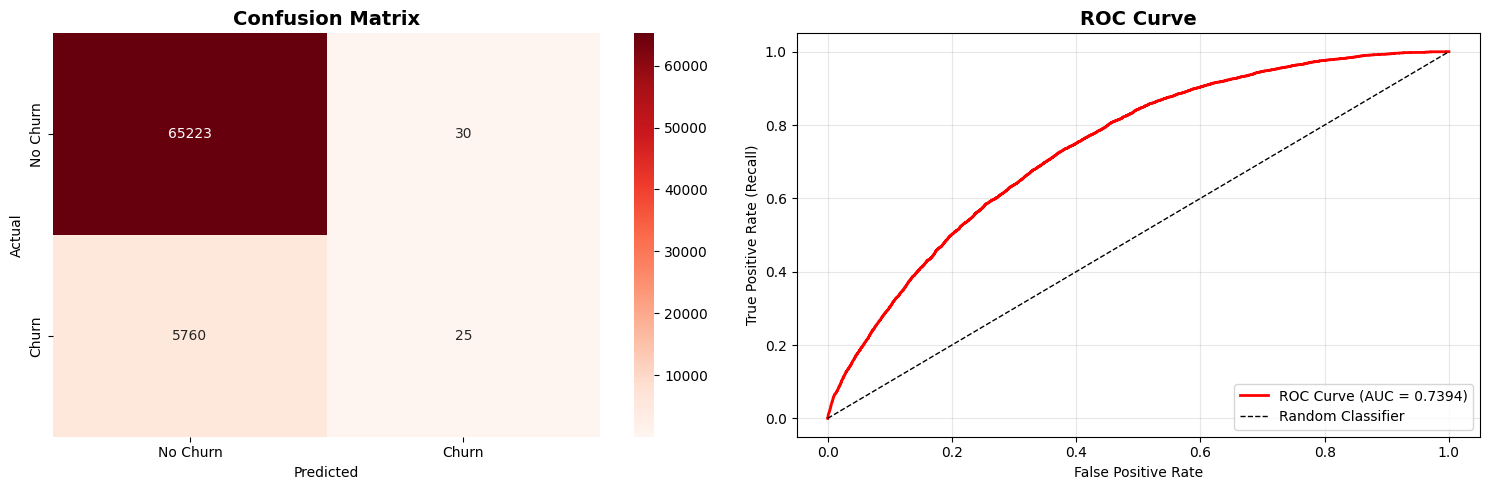

In [25]:
# Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Churn', 'Churn'])
axes[0].set_yticklabels(['No Churn', 'Churn'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_roc:.4f})', color='red')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()